In [ ]:
## Importing libraries

!pip install librosa
!pip install tqdm
!pip install plotly
import os
import random
import sys
import glob
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import warnings
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm
import plotly.offline as py

warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
py.init_notebook_mode(connected=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/Audio_Speech_Actors_01-24.zip' .
!unzip -q Audio_Speech_Actors_01-24.zip

In [ ]:
import os
import glob

def metadata(basepath):
    df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender', 'intensity', 'statement', 'repetition', 'emotion'])
    count = 0

    actor_folders = glob.glob(basepath)
    for actor_folder in actor_folders:
     if os.path.isdir(actor_folder):
        try:
            actor = int(os.path.basename(actor_folder).split('_')[-1])
        except ValueError:
            print("Invalid actor folder:", actor_folder)
            continue

        actor_files = glob.glob(actor_folder + '/*.wav')
        for file_path in actor_files:
            print("Actor folder:", actor_folder)  # Print the actor_folder for troubleshooting
            actor = int(os.path.basename(actor_folder).split('_')[-1])  # Extract the actor number correctly
            filename = os.path.basename(file_path).split('.')[0].split('-')
            if len(filename) == 7:
                src = int(filename[1])
                emotion = int(filename[2])

                gender = "female" if actor % 2 == 0 else "male"
                intensity = 0 if filename[3] == '01' else 1
                statement = 0 if filename[4] == '01' else 1
                repeat = 0 if filename[5] == '01' else 1

                df.loc[count] = [file_path, src, actor, gender, intensity, statement, repeat, emotion]
                count += 1


    labels = []
    y = []
    for i in range(len(df)):
        if df.emotion.iloc[i] == 1:
            label = "_neutral"
            y.append(1)
        elif df.emotion.iloc[i] == 2:
            label = "_calm"
            y.append(2)
        elif df.emotion.iloc[i] == 3:
            label = "_happy"
            y.append(3)
        elif df.emotion.iloc[i] == 4:
            label = "_sad"
            y.append(4)
        elif df.emotion.iloc[i] == 5:
            label = "_angry"
            y.append(5)
        elif df.emotion.iloc[i] == 6:
            label = "_fearful"
            y.append(6)
        elif df.emotion.iloc[i] == 7:
            label = "_disgust"
            y.append(7)
        elif df.emotion.iloc[i] == 8:
            label = "_surprised"
            y.append(8)
        else:
            label = "_none"

        # Add gender to the label
        labels.append(label)

    df['label'] = labels

    return df

basepath = '/content/Actor_*'
df = metadata(basepath)


Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor fo

In [ ]:
y = df.emotion.values.tolist()

In [ ]:
class Spectrograms():
    def __init__(self, df, datasettype, outputpath, sample=False, augmentation=False, mel=True, mfcc=False, spectral=False, mfccbanks=20, n_mels=128):
        self.df = df
        self.augmentation = augmentation
        self.mel = mel
        self.mfcc = mfcc
        self.spectral = spectral
        self.mfccbanks = mfccbanks
        self.n_mels = n_mels
        self.outputpath = outputpath
        self.datasettype = datasettype
        self.sample = sample

    def get_spectrograms(self):
        if self.sample:
            x, sample_rate = librosa.load(self.df.index[0])
            self.generate(x, sample_rate, '', 0)

        else:
            for file in tqdm(range(self.df.shape[0])):
                emotion = df.iloc[file, df.columns.get_loc('label')]
                path = self.outputpath+self.datasettype+"/"+str(emotion)+"/"

                if not os.path.isdir(path):
                    os.makedirs(path)

                ## Reading signal from .wav file
                x, sample_rate = librosa.load(self.df.index[file])
                emo = df.iloc[file, df.columns.get_loc('emotion')]
                self.generate(x, sample_rate, path, file, emo)


    def generate(self, x, sample_rate, path, count, emo):
        if self.mel:
            mel_features = librosa.feature.melspectrogram(y=x, sr=sample_rate, n_mels=self.n_mels)

            log_mel_features = librosa.power_to_db(mel_features, ref=np.max)
            fig = plt.figure(figsize=(12,4))
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            librosa.display.specshow(log_mel_features, sr=sample_rate, x_axis='time', y_axis='mel')
            if self.sample:
                plt.show()
            else:
                plt.savefig(path+str(emo)+"-"+str(count)+".jpg")

                plt.close()

        if self.mfcc:
            mfcc_features = librosa.feature.mfcc(x, sr=sample_rate, n_mfcc=self.mfccbanks)
            fig = plt.figure(figsize=(12,4))
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            librosa.display.specshow(mfcc_features, sr=sample_rate, x_axis='time', y_axis='mel')
            if self.sample:
                plt.show()
            else:
                plt.savefig(path+"mfccspectrogram_"+str(count)+".jpg")
                plt.close()

        if self.spectral:
            spectral_features = librosa.feature.spectral_contrast(x, sr=sample_rate)
            fig = plt.figure(figsize=(12,4))
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            librosa.display.specshow(spectral_features, sr=sample_rate, x_axis='time', y_axis='mel')
            if self.sample:
                plt.show()
            else:
                plt.savefig(path+"spectralspectrogram_"+str(count)+".jpg")
                plt.close()

In [ ]:
df_new = metadata('/content/Actor_*')


Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor folder: /content/Actor_08
Actor fo

In [ ]:
df_new.index = df_new.path
df_new = df_new.drop("path", axis=1)

In [ ]:
spectrograms = Spectrograms(df_new, 'images_new', '/content/spectrograms', sample=False)
spectrograms.get_spectrograms()

  0%|          | 5/1440 [00:03<14:34,  1.64it/s]


KeyboardInterrupt: ignored

<Figure size 1200x400 with 0 Axes>

In [ ]:
!pip install opencv-python
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
categories = os.listdir("/content/spectrogramsimages_new")
len(categories)

8

In [ ]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img_array = Image.fromarray(img, 'RGB')

            #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
            resized_img = img_array.resize((227, 227))

            img_lst.append(np.array(resized_img))

            labels.append(index)
    return img_lst, labels

fpath = "/content/spectrogramsimages_new"
images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))


No. of images loaded =  1440 
No. of labels loaded =  1440
<class 'list'> <class 'list'>


In [ ]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1440, 227, 227, 3) 
Labels shape =  (1440,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
#1-step in data shuffling
random_seed=42
#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 1437 1438 1439]

'n' values after shuffling =  [ 168  605  548 ... 1294  860 1126]


In [ ]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (1440, 227, 227, 3) 
Labels shape after shuffling =  (1440,)


In [ ]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (1440, 227, 227, 3)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (1152, 227, 227, 3)
y_train shape =  (1152,)

x_test shape =  (288, 227, 227, 3)
y_test shape =  (288,)


In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization


In [ ]:
model=Sequential()

#1 conv layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(227,227,3)))

#1 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#2 conv layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#3 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())


model.add(Flatten())

#1 dense layer
model.add(Dense(4096,input_shape=(227,227,3),activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#2 dense layer
model.add(Dense(4096,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#3 dense layer
model.add(Dense(1000,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#output layer
model.add(Dense(20,activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                        

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
%%time
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
36/36 [==============================] - 19s 39ms/step - loss: 3.1263 - accuracy: 0.2231
Epoch 2/100
36/36 [==============================] - 1s 34ms/step - loss: 2.3491 - accuracy: 0.3142
Epoch 3/100
36/36 [==============================] - 1s 35ms/step - loss: 1.9770 - accuracy: 0.3568
Epoch 4/100
36/36 [==============================] - 1s 34ms/step - loss: 1.9286 - accuracy: 0.3689
Epoch 5/100
36/36 [==============================] - 1s 34ms/step - loss: 1.7160 - accuracy: 0.4201
Epoch 6/100
36/36 [==============================] - 1s 35ms/step - loss: 1.6317 - accuracy: 0.4236
Epoch 7/100
36/36 [==============================] - 1s 41ms/step - loss: 1.5180 - accuracy: 0.4523
Epoch 8/100
36/36 [==============================] - 2s 42ms/step - loss: 1.5018 - accuracy: 0.4800
Epoch 9/100
36/36 [==============================] - 2s 47ms/step - loss: 1.3572 - accuracy: 0.5130
Epoch 10/100
36/36 [==============================] - 1s 40ms/step - loss: 1.3219 - accuracy: 0.528

In [ ]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)


9/9 [==============================] - 0s 19ms/step


In [ ]:
predictions
y_test
new_Ytest = y_test.astype(int)
new_Ytest

array([1, 2, 0, 1, 1, 5, 3, 2, 1, 6, 7, 4, 3, 3, 4, 5, 2, 3, 7, 4, 3, 7,
       1, 2, 4, 7, 7, 5, 3, 2, 1, 4, 4, 3, 2, 0, 2, 3, 1, 1, 1, 5, 2, 3,
       3, 1, 0, 3, 6, 2, 3, 5, 1, 7, 1, 2, 6, 5, 2, 0, 2, 6, 3, 3, 4, 7,
       7, 4, 6, 4, 7, 1, 6, 6, 7, 3, 1, 6, 0, 1, 4, 3, 7, 7, 3, 3, 5, 4,
       7, 3, 0, 1, 0, 3, 6, 5, 4, 2, 4, 7, 0, 1, 1, 1, 6, 5, 0, 4, 7, 0,
       5, 0, 5, 1, 1, 6, 4, 1, 0, 6, 2, 2, 7, 1, 3, 7, 2, 3, 6, 6, 2, 3,
       3, 2, 3, 5, 4, 1, 2, 6, 0, 7, 2, 2, 5, 5, 3, 7, 6, 6, 3, 2, 6, 5,
       6, 5, 7, 3, 3, 1, 3, 2, 6, 5, 4, 1, 0, 4, 7, 5, 1, 6, 4, 2, 3, 2,
       5, 2, 6, 1, 2, 6, 5, 7, 7, 2, 1, 6, 7, 2, 7, 1, 2, 1, 5, 4, 4, 5,
       5, 7, 3, 6, 1, 3, 7, 0, 7, 4, 2, 4, 0, 6, 2, 4, 4, 2, 4, 3, 4, 5,
       1, 4, 7, 3, 3, 2, 3, 4, 3, 5, 1, 5, 2, 4, 0, 2, 6, 1, 4, 4, 3, 3,
       2, 5, 2, 7, 2, 1, 7, 0, 1, 3, 0, 7, 2, 4, 1, 0, 6, 5, 3, 5, 6, 3,
       6, 6, 0, 7, 3, 7, 1, 7, 5, 6, 4, 4, 7, 6, 7, 4, 6, 4, 1, 1, 2, 1,
       2, 6])

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(new_Ytest, predicted_classes)
print(report)



              precision    recall  f1-score   support

           0       0.16      0.67      0.26        21
           1       0.00      0.00      0.00        42
           2       0.58      0.52      0.55        42
           3       0.94      0.34      0.50        44
           4       0.42      0.95      0.58        37
           5       1.00      0.43      0.60        30
           6       0.77      0.29      0.42        35
           7       0.29      0.30      0.29        37

    accuracy                           0.42       288
   macro avg       0.52      0.44      0.40       288
weighted avg       0.53      0.42      0.40       288



In [ ]:
from sklearn.metrics import confusion_matrix

new_Ytest = new_Ytest.astype(int)
matrix = confusion_matrix(new_Ytest, predicted_classes)
print(matrix)


[[14  0  0  0  5  0  0  2]
 [24  0  5  0  5  0  2  6]
 [11  0 22  0  6  0  0  3]
 [19  0  2 15  3  0  0  5]
 [ 1  0  0  0 35  0  0  1]
 [ 2  0  2  1  7 13  1  4]
 [ 6  0  3  0 10  0 10  6]
 [10  0  4  0 12  0  0 11]]


9/9 [==============================] - 0s 20ms/step


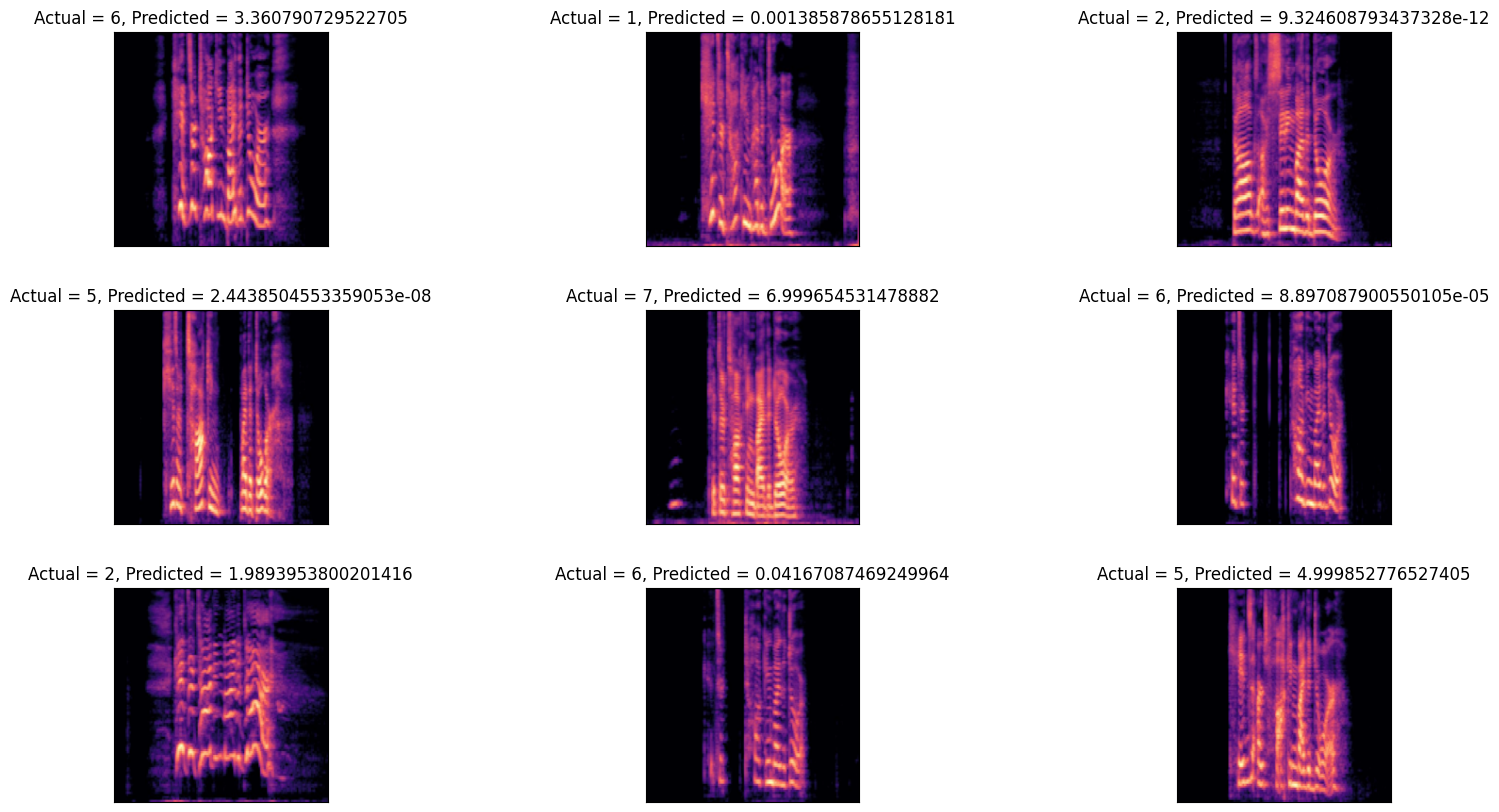

In [ ]:
pred = model.predict(x_test)
plt.figure(1 , figsize = (19 , 10))
n = 0

for i in range(9):
    n += 1
    r = np.random.randint( 0, x_test.shape[0], 1)

    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)

    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(y_test[r[0]] , y_test[r[0]]*pred[r[0]][y_test[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

In [ ]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [ ]:

IMG_SHAPE = images.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 32)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 32)                4946816   
                                                                 
 sequential_2 (Sequential)   (None, 227, 227, 3)       5101371   
                                                                 
Total params: 10,048,187
Trainable params: 10,048,187
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = autoencoder.fit(x=x_train, y=x_train, epochs=20,
                validation_data=[x_test, x_test])

Epoch 1/20


45/45 [==============================] - 1s 17ms/step


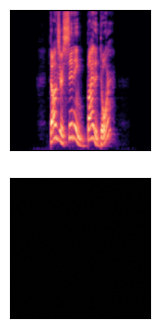

Accuracy= 0.7876681089401245 



In [ ]:
decoded_imgs = autoencoder.predict(images)

n = 1
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(227, 227,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(227, 227,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Accuracy=",1-np.mean(abs(images-decoded_imgs)),'\n')

45/45 [==============================] - 1s 15ms/step


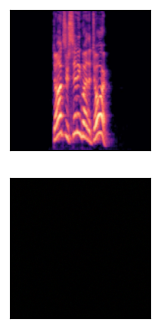

Accuracy= 0.7876681089401245 



In [ ]:
decoded_imgs = autoencoder.predict(images)
n = 1
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(images[i].reshape(227, 227,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(227, 227,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Accuracy=",1-np.mean(abs(images-decoded_imgs)),'\n')


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(decoded_imgs, labels, test_size = 0.2, random_state = random_seed)

print("x_train shape = ",X_train.shape)
print("y_train shape = ",Y_train.shape)
print("\nx_test shape = ",X_test.shape)
print("y_test shape = ",Y_test.shape)

x_train shape =  (1152, 227, 227, 3)
y_train shape =  (1152,)

x_test shape =  (288, 227, 227, 3)
y_test shape =  (288,)


In [ ]:
%%time
model.fit(X_train, Y_train, epochs=300, batch_size=32)

Epoch 1/300
36/36 [==============================] - 1s 37ms/step - loss: 3.5410 - accuracy: 0.1606
Epoch 2/300
36/36 [==============================] - 1s 42ms/step - loss: 2.1843 - accuracy: 0.2222
Epoch 3/300
36/36 [==============================] - 1s 38ms/step - loss: 1.9932 - accuracy: 0.2717
Epoch 4/300
36/36 [==============================] - 1s 35ms/step - loss: 1.9580 - accuracy: 0.3194
Epoch 5/300
36/36 [==============================] - 1s 36ms/step - loss: 1.9042 - accuracy: 0.3264
Epoch 6/300
36/36 [==============================] - 1s 39ms/step - loss: 1.7798 - accuracy: 0.3550
Epoch 7/300
36/36 [==============================] - 1s 38ms/step - loss: 1.7641 - accuracy: 0.3872
Epoch 8/300
36/36 [==============================] - 1s 36ms/step - loss: 1.6462 - accuracy: 0.3880
Epoch 9/300
36/36 [==============================] - 1s 35ms/step - loss: 1.5797 - accuracy: 0.4245
Epoch 10/300
36/36 [==============================] - 1s 35ms/step - loss: 1.5133 - accuracy: 0.4436

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 5.906783103942871
Test accuracy: 0.3263888955116272


In [ ]:
predictions_new = np.argmax(model.predict(X_test), axis=-1)
predictions_new
y_test
new_Ytest_new = y_test.astype(int)
new_Ytest_new

9/9 [==============================] - 0s 20ms/step


array([1, 2, 0, 1, 1, 5, 3, 2, 1, 6, 7, 4, 3, 3, 4, 5, 2, 3, 7, 4, 3, 7,
       1, 2, 4, 7, 7, 5, 3, 2, 1, 4, 4, 3, 2, 0, 2, 3, 1, 1, 1, 5, 2, 3,
       3, 1, 0, 3, 6, 2, 3, 5, 1, 7, 1, 2, 6, 5, 2, 0, 2, 6, 3, 3, 4, 7,
       7, 4, 6, 4, 7, 1, 6, 6, 7, 3, 1, 6, 0, 1, 4, 3, 7, 7, 3, 3, 5, 4,
       7, 3, 0, 1, 0, 3, 6, 5, 4, 2, 4, 7, 0, 1, 1, 1, 6, 5, 0, 4, 7, 0,
       5, 0, 5, 1, 1, 6, 4, 1, 0, 6, 2, 2, 7, 1, 3, 7, 2, 3, 6, 6, 2, 3,
       3, 2, 3, 5, 4, 1, 2, 6, 0, 7, 2, 2, 5, 5, 3, 7, 6, 6, 3, 2, 6, 5,
       6, 5, 7, 3, 3, 1, 3, 2, 6, 5, 4, 1, 0, 4, 7, 5, 1, 6, 4, 2, 3, 2,
       5, 2, 6, 1, 2, 6, 5, 7, 7, 2, 1, 6, 7, 2, 7, 1, 2, 1, 5, 4, 4, 5,
       5, 7, 3, 6, 1, 3, 7, 0, 7, 4, 2, 4, 0, 6, 2, 4, 4, 2, 4, 3, 4, 5,
       1, 4, 7, 3, 3, 2, 3, 4, 3, 5, 1, 5, 2, 4, 0, 2, 6, 1, 4, 4, 3, 3,
       2, 5, 2, 7, 2, 1, 7, 0, 1, 3, 0, 7, 2, 4, 1, 0, 6, 5, 3, 5, 6, 3,
       6, 6, 0, 7, 3, 7, 1, 7, 5, 6, 4, 4, 7, 6, 7, 4, 6, 4, 1, 1, 2, 1,
       2, 6])

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest_new, predictions_new)
print(report)

              precision    recall  f1-score   support

           0       0.29      0.10      0.14        21
           1       0.50      0.31      0.38        42
           2       0.46      0.26      0.33        42
           3       0.41      0.20      0.27        44
           4       0.33      0.86      0.47        37
           5       0.24      0.30      0.27        30
           6       0.37      0.29      0.32        35
           7       0.17      0.22      0.19        37

    accuracy                           0.33       288
   macro avg       0.35      0.32      0.30       288
weighted avg       0.36      0.33      0.31       288



In [ ]:
from sklearn.metrics import classification_report, matthews_corrcoef

report = classification_report(new_Ytest_new, predictions_new)
print(report)

# Calculate MCC for each emotion
emotions = [0, 1, 2, 3, 4, 5, 6, 7]  # Replace with your actual emotion labels
mcc_scores = {}
for emotion in emotions:
    emotion_indices = (new_Ytest_new == emotion)
    emotion_predictions = predictions_new[emotion_indices]
    emotion_labels = new_Ytest_new[emotion_indices]
    mcc_scores[emotion] = matthews_corrcoef(emotion_labels, emotion_predictions)

# Print MCC scores for each emotion
for emotion, mcc in mcc_scores.items():
    print(f"MCC for emotion {emotion}: {mcc}")



              precision    recall  f1-score   support

           0       0.29      0.10      0.14        21
           1       0.50      0.31      0.38        42
           2       0.46      0.26      0.33        42
           3       0.41      0.20      0.27        44
           4       0.33      0.86      0.47        37
           5       0.24      0.30      0.27        30
           6       0.37      0.29      0.32        35
           7       0.17      0.22      0.19        37

    accuracy                           0.33       288
   macro avg       0.35      0.32      0.30       288
weighted avg       0.36      0.33      0.31       288

MCC for emotion 0: 0.0
MCC for emotion 1: 0.0
MCC for emotion 2: 0.0
MCC for emotion 3: 0.0
MCC for emotion 4: 0.0
MCC for emotion 5: 0.0
MCC for emotion 6: 0.0
MCC for emotion 7: 0.0


Epoch 1/20
36/36 [==============================] - 4s 109ms/step - loss: 3.2930 - accuracy: 0.3394 - val_loss: 125.6954 - val_accuracy: 0.1528
Epoch 2/20
36/36 [==============================] - 2s 58ms/step - loss: 1.3299 - accuracy: 0.5321 - val_loss: 27.3696 - val_accuracy: 0.1562
Epoch 3/20
36/36 [==============================] - 2s 44ms/step - loss: 0.9142 - accuracy: 0.6797 - val_loss: 7.0535 - val_accuracy: 0.2743
Epoch 4/20
36/36 [==============================] - 2s 44ms/step - loss: 0.6938 - accuracy: 0.7509 - val_loss: 8.9155 - val_accuracy: 0.1667
Epoch 5/20
36/36 [==============================] - 2s 44ms/step - loss: 0.4945 - accuracy: 0.8194 - val_loss: 2.1419 - val_accuracy: 0.4132
Epoch 6/20
36/36 [==============================] - 1s 39ms/step - loss: 0.2889 - accuracy: 0.9071 - val_loss: 2.3464 - val_accuracy: 0.4340
Epoch 7/20
36/36 [==============================] - 1s 40ms/step - loss: 0.2175 - accuracy: 0.9288 - val_loss: 2.4210 - val_accuracy: 0.5069
Epoch 8/2

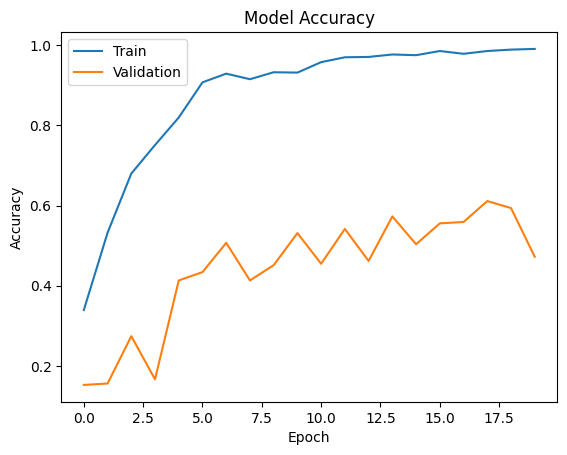

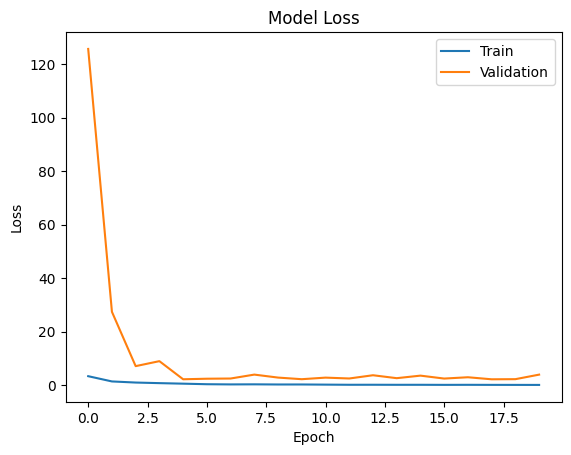

In [ ]:

import matplotlib.pyplot as plt

# Train the model and obtain the history object
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

# Plot the accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
